# Imports

In [1]:
# Hakim
import numpy as np
import pandas as pd
from sklearn.svm import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    confusion_matrix,
    balanced_accuracy_score,
    accuracy_score,
    precision_recall_curve,
    roc_curve,
)
import matplotlib.pyplot as plt
from sklearn.inspection import DecisionBoundaryDisplay
from imblearn.over_sampling import SMOTE
from collections import Counter
import pickle

# Data Preprocessing 

In [2]:
train_df = pd.read_csv("/kaggle/input/frauddetection-data/fraudTrain.csv")

In [3]:
test_df = pd.read_excel("/kaggle/input/frauddetection-data/fraudTest.xlsx")

# We need these values to use them later in the model deployment

In [4]:
dict(
    zip(
        train_df["category"].unique().tolist(),
        train_df["category"].astype("category").cat.codes.unique().tolist(),
    )
)

{'misc_net': 9,
 'grocery_pos': 4,
 'entertainment': 0,
 'gas_transport': 2,
 'misc_pos': 10,
 'grocery_net': 3,
 'shopping_net': 12,
 'shopping_pos': 13,
 'food_dining': 1,
 'personal_care': 11,
 'health_fitness': 5,
 'travel': 14,
 'kids_pets': 8,
 'home': 6,
 'kids_': 7}

In [5]:
train_df["Amount"].mean()

70.25615704174125

* let's see whats the type of data we are working with

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1002104 entries, 0 to 1002103
Data columns (total 10 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   ID           1002104 non-null  int64  
 1   Time         1002104 non-null  object 
 2   Card Number  1002104 non-null  float64
 3   merchant     1002104 non-null  object 
 4   category     1002104 non-null  object 
 5   Amount       1002103 non-null  float64
 6   firstName    1002103 non-null  object 
 7   lastName     1002103 non-null  object 
 8   trans_num    1002103 non-null  object 
 9   is_fraud     1002103 non-null  float64
dtypes: float64(3), int64(1), object(6)
memory usage: 76.5+ MB


In [7]:
average_amount_all = train_df["Amount"].mean()
train_df["Amount_diff_avg"] = train_df["Amount"] - average_amount_all

train_df["Time"] = pd.to_datetime(train_df["Time"])
train_df["Hour"] = train_df["Time"].dt.hour
train_df["DayOfWeek"] = train_df["Time"].dt.dayofweek
train_df["IsWeekend"] = train_df["DayOfWeek"] >= 5

train_df["LogAmount"] = np.log1p(train_df["Amount"])

train_df["TransactionCountPerCard"] = train_df.groupby("Card Number")[
    "Card Number"
].transform("count")

train_df["TimeSinceLastTransaction"] = (
    train_df.groupby("Card Number")["Time"].diff().dt.total_seconds()
)
train_df["TimeSinceLastTransaction"] = train_df["TimeSinceLastTransaction"].fillna(0)

merchant_freq = train_df["merchant"].value_counts() / len(train_df)
category_freq = train_df["category"].value_counts() / len(train_df)
train_df["MerchantFreq"] = train_df["merchant"].map(merchant_freq)
train_df["CategoryFreq"] = train_df["category"].map(category_freq)

train_df["merchant"] = train_df["merchant"].astype("category").cat.codes
train_df["category"] = train_df["category"].astype("category").cat.codes

train_df.dropna(inplace=True)
train_df.drop(columns=["ID", "firstName", "lastName", "trans_num"], inplace=True)
train_df.head()

,Time,Card Number,merchant,category,Amount,is_fraud,Amount_diff_avg,Hour,DayOfWeek,IsWeekend,LogAmount,TransactionCountPerCard,TimeSinceLastTransaction,MerchantFreq,CategoryFreq
0,2019-01-01 00:00:00,2.700000e+15,514,9,4.97,0.0,-65.286157,0,1,False,1.786747,1578,0.0,0.001002,0.048654
1,2019-01-01 00:00:00,6.300000e+11,241,4,107.23,0.0,36.973843,0,1,False,4.684259,13879,0.0,0.001920,0.095141
2,2019-01-01 00:00:00,3.890000e+13,390,0,220.11,0.0,149.853843,0,1,False,5.398660,1546,0.0,0.001447,0.072554
3,2019-01-01 00:01:00,3.530000e+15,360,2,45.00,0.0,-25.256157,0,1,False,3.828641,21329,0.0,0.001986,0.101514
4,2019-01-01 00:03:00,3.760000e+14,297,10,41.96,0.0,-28.296157,0,1,False,3.760269,11846,0.0,0.001199,0.061529


# We created alot of columns , let's claculate which ones are important using correlation

In [8]:
np.abs(train_df[train_df.columns].corr()["is_fraud"][:]).sort_values(ascending=False)

is_fraud                    1.000000
Amount                      0.217171
Amount_diff_avg             0.217171
LogAmount                   0.119004
category                    0.019780
Hour                        0.012535
Time                        0.011241
TimeSinceLastTransaction    0.010764
MerchantFreq                0.007783
CategoryFreq                0.005361
Card Number                 0.003599
IsWeekend                   0.003119
TransactionCountPerCard     0.001809
DayOfWeek                   0.000755
merchant                    0.000502
Name: is_fraud, dtype: float64

* Drop the columns with the least effect on the label

In [9]:
train_df.drop(
    columns=[
        "merchant",
        "DayOfWeek",
        "TransactionCountPerCard",
        "IsWeekend",
        "Card Number",
        "CategoryFreq",
        "MerchantFreq",
        "LogAmount",
        "TimeSinceLastTransaction",
        "Time",
    ],
    inplace=True,
)

In [10]:
train_df.head()

,category,Amount,is_fraud,Amount_diff_avg,Hour
0,9,4.97,0.0,-65.286157,0
1,4,107.23,0.0,36.973843,0
2,0,220.11,0.0,149.853843,0
3,2,45.00,0.0,-25.256157,0
4,10,41.96,0.0,-28.296157,0


# Applying the used tranformations on the test data

In [11]:
average_amount_all = test_df["Amount"].mean()
test_df["Amount_diff_avg"] = test_df["Amount"] - average_amount_all

test_df["Time"] = pd.to_datetime(test_df["Time"])
test_df["Hour"] = test_df["Time"].dt.hour

test_df["category"] = test_df["category"].astype("category").cat.codes
test_df.dropna(inplace=True)
test_df.drop(
    columns=[
        "ID",
        "firstName",
        "lastName",
        "trans_num",
        "merchant",
        "Time",
        "Card Number",
    ],
    inplace=True,
)
test_df.head()

,category,Amount,is_fraud,Amount_diff_avg,Hour
0,10,2.86,0,-66.53281,12
1,10,29.84,0,-39.55281,12
2,5,41.28,0,-28.11281,12
3,9,60.05,0,-9.34281,12
4,13,3.19,0,-66.20281,12


* creating training and testing data

In [57]:
y_train = np.array(train_df["is_fraud"])
y_test = np.array(test_df["is_fraud"])

In [58]:
x_train = np.array(train_df.drop("is_fraud", axis=1))
x_test = np.array(test_df.drop("is_fraud", axis=1))

* To get the percentage of positives in the data 

In [59]:
y_train.sum() / len(y_train) * 100

0.570101077434156

#  The data is highly imbalanced ,only 0.5% of the data is positive , which makes the model overfit

* To make the data balanced , we will imbalanced learn's SMOTE

* Count before applying SMOTE

In [60]:
Counter(y_train)

Counter({0.0: 996390, 1.0: 5713})

In [61]:
# Apply SMOTE
smote = SMOTE(random_state=42)
x_train, y_train = smote.fit_resample(x_train, y_train)

* Count after applying SMOTE

In [62]:
Counter(y_train)

Counter({0.0: 996390, 1.0: 996390})

# SMOTE just adds 1 class at the end , so we need to shuffle the data

In [63]:
y_train[1200000:]

array([1., 1., 1., ..., 1., 1., 1.])

In [64]:
np.random.seed(42)
np.random.shuffle(x_train)
np.random.seed(42)  # for some reason the seed has to be set twice
np.random.shuffle(y_train)

# Let's Start with the Random Forest model

In [66]:
# Random Forest model
rf = RandomForestClassifier(random_state=42)
rf.fit(x_train, y_train)

RandomForestClassifier(random_state=42)

# Model Evaluation

In [55]:
def get_results(model):
    y_pred = model.predict(x_test)
    precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred)
    p_score = precision_score(y_test, y_pred)
    r_score = recall_score(y_test, y_pred)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    plt.plot(fpr, tpr, label="ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve for Classification Model")
    plt.show()
    auc_prc = roc_auc_score(y_test, y_pred)
    balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print("accuracy          : ", accuracy)
    print("balanced accuracy : ", balanced_accuracy)
    print("F1 score          : ", f1)
    print("precision score   : ", p_score)
    print("recall score      : ", r_score)
    print("AUC-PRC scoree    : ", auc_prc)
    cm = confusion_matrix(y_test, y_pred)

    fig, ax = plt.subplots(figsize=(5, 5))
    ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.7)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(x=j, y=i, s=cm[i, j], va="center", ha="center", size="xx-large")
    plt.xlabel("Predections", fontsize=18)
    plt.ylabel("Actuals", fontsize=18)
    plt.title("Confusion Matrix", fontsize=18)
    plt.show()

# Random Forest results

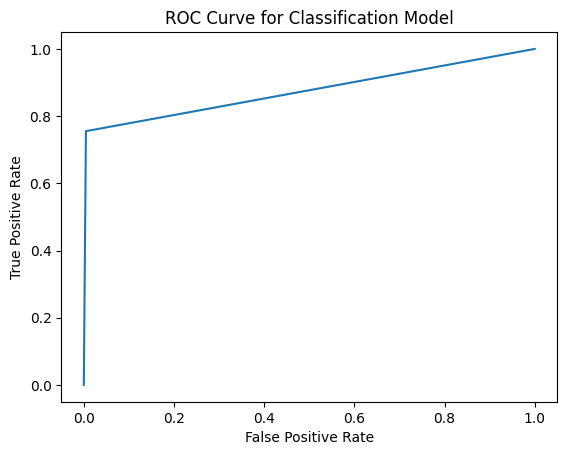

accuracy          :  0.994412643800194
balanced accuracy :  0.8752920658664064
F1 score          :  0.5106382978723405
precision score   :  0.38571428571428573
recall score      :  0.7552447552447552
AUC-PRC scoree    :  0.8752920658664064


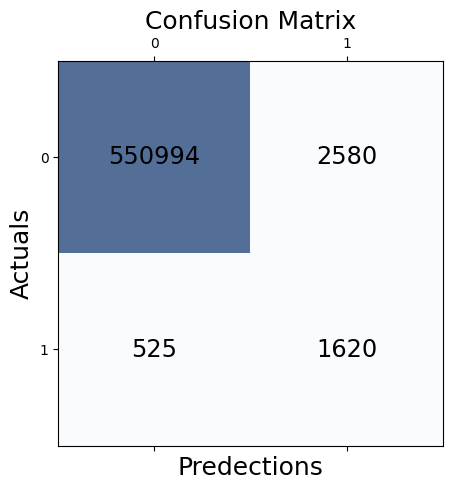

In [67]:
get_results(rf)

# Now we will try a different approach

* Instead of trying to match the number of the 1 class with the 0 class using SMOTE, we will take just a part of the 0  class (16,000 samples) with all the 1 class (5,713 samples) in the training data

In [44]:
y_train = np.array(train_df["is_fraud"])
x_train = np.array(train_df.drop("is_fraud", axis=1))

* Number of the 1 class in all of the training data

In [45]:
y_train.sum()

5713.0

In [46]:
balanced_x_train = np.concatenate(
    (x_train[np.where(y_train == 1)], x_train[np.where(y_train[:16000] == 0)])
)
balanced_y_train = np.concatenate(
    (y_train[np.where(y_train == 1)], y_train[np.where(y_train[:16000] == 0)])
)

In [47]:
Counter(balanced_y_train)

Counter({0.0: 15897, 1.0: 5713})

# Now let's try RandomForest on the new data

In [53]:
# Random Forest model
rf2 = RandomForestClassifier(random_state=42)
rf2.fit(balanced_x_train, balanced_y_train)

RandomForestClassifier(random_state=42)

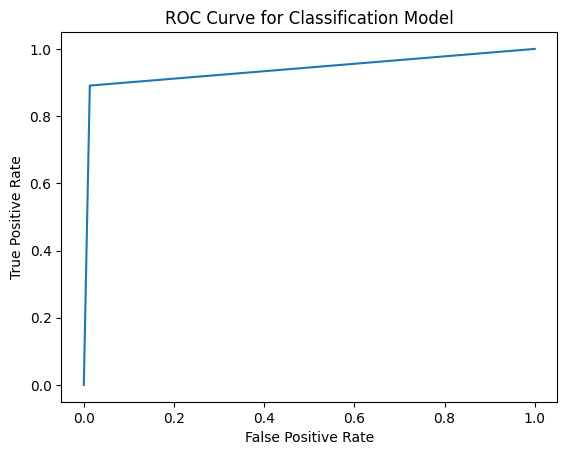

accuracy          :  0.9863366197664647
balanced accuracy :  0.9388077376203625
F1 score          :  0.33482260183968465
precision score   :  0.20614886731391585
recall score      :  0.8909090909090909
AUC-PRC scoree    :  0.9388077376203624


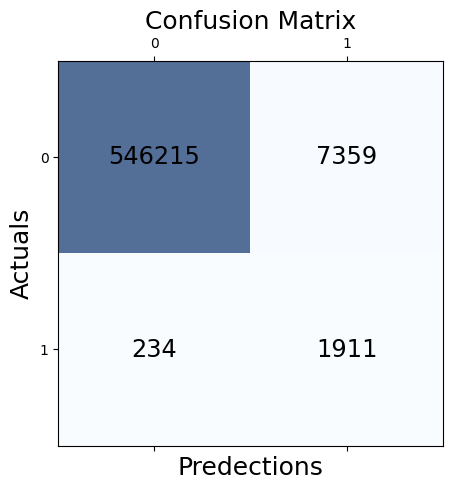

In [56]:
get_results(rf2)

# Now let's try SVM

In [48]:
svm = SVC(kernel="rbf", gamma=0.4, C=1.0)
svm.fit(balanced_x_train, balanced_y_train)

SVC(gamma=0.4)

# SVM Model results

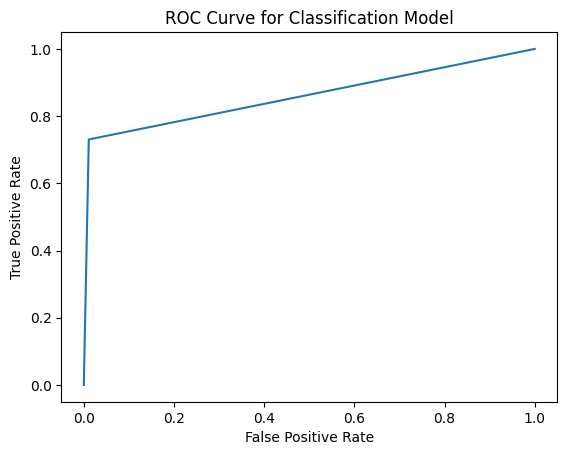

accuracy          :  0.9880065284793214
balanced accuracy :  0.8597701553228727
F1 score          :  0.3198285539340749
precision score   :  0.20472955317481056
recall score      :  0.7305361305361305
AUC-PRC scoree    :  0.8597701553228728


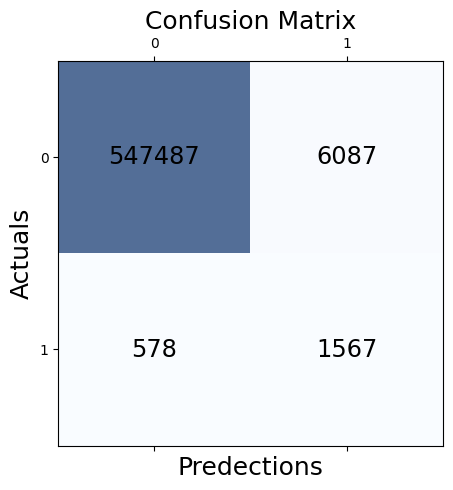

In [68]:
get_results(svm)

# Saving the models to deploy them later.

In [ ]:
filename = "svm_model2.pth"


with open(filename, "wb") as f:
    pickle.dump(svm, f)

print(f"Model saved to {filename}")

In [ ]:
filename = "rf_model.pth"

with open(filename, "wb") as f:
    pickle.dump(rf, f)

print(f"Model saved to {filename}")